# **Rapport TPs Traitement de l'image**

In [113]:
# Visionneuse externe interactive
# %matplotlib
#imports
import numpy as np # Tableaux
import scipy.ndimage as scp # Correlation et convolution
import matplotlib.pyplot as plt # Visionneur et trac ́es
from matplotlib.colors import LogNorm # echelle logarithmique
import skimage
from scipy import fftpack # Fourier 2D
from scipy import signal

# chemin d'accès à mes images 
my_path = "Images/"

## **Microscopie électronique**
**Le principe du microscope électronique est de faire passer un flux d’électrons au travers de lentilles magnétiques puis d’une fine tranche de l’échantillon à observer.<br>
On obtient alors une image I grossie de l’échantillon (image cryoEM).<br>
Cependant les lentilles magnétiques ne sont pas parfaites et elles produisent des aberrations qui doivent être corrigees (en plus du bruit inhérent au flux életronique).<br>
La transformee de Fourier _J_ de l’image _I_ permet de visualiser les aberrations.**
#### **1. Afficher la TdF de l'image cryoEM.**

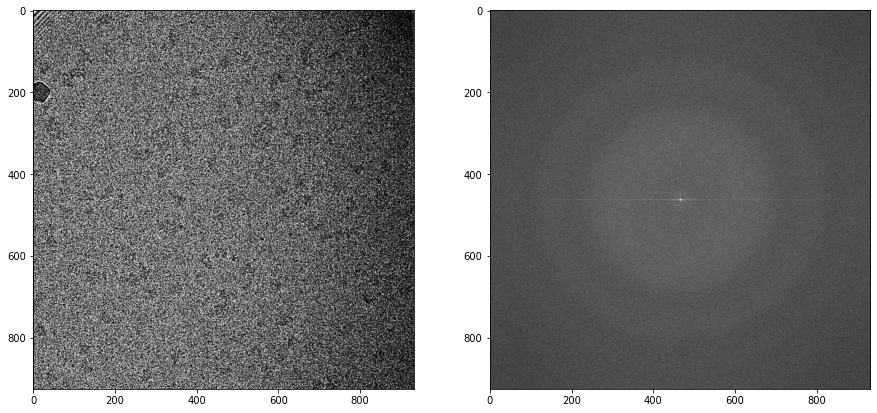

In [133]:
cryoem = skimage.io.imread(my_path+"cryoEM.png")

def calculerTdF(image):
    imageGray = image
    if image.ndim != 2 :
        imageGray = skimage.color.rgb2gray(image)
    TF = fftpack.fft2(imageGray)
    module = abs(TF)
    return fftpack.fftshift(module)

def afficherTdF(image):
    shift = calculerTdF(image)
    f, axarr = plt.subplots(1,2,figsize=(15,15))
    axarr[0].imshow(image,cmap='gray')
    axarr[1].imshow(shift,norm=LogNorm(vmin=5),cmap='gray')
    return shift

cryoem_tdf = afficherTdF(cryoem)

**Quels sont les éléments notables de l'image ? Est-ce attendu ?**

On remarque la présence de formes circulaires centrés, formés par tous les points à la même fréquence.
Cela est attendu car formé par l'échantillon observé. Cependant, ces formes ne sont pas nets dû à la présence de bruit inhérent au flux électronique.
De plus, on voit également un point blanc au centre de l'image ainsi que deux points de par et d'autre de lui verticalement mais également une ligne blanche horizontal centré verticalement.
On peut supposer que cela n'est pas attendu et est dû aux aberrations provoqués par les lentilles magnétiques.

#### **2. Afficher la colonne centrale de la TDF.**

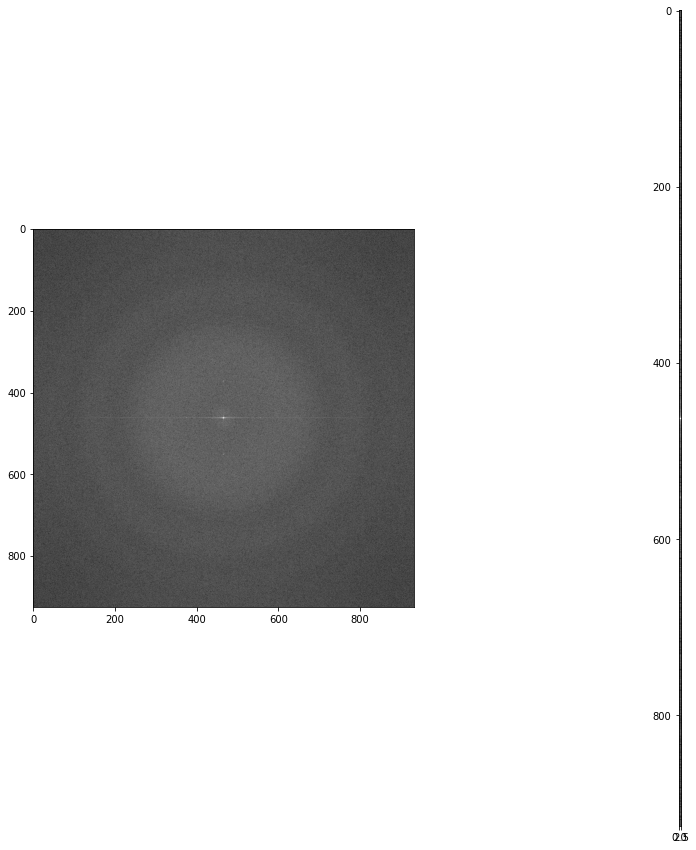

In [110]:
def afficherColonneCentrale(image):
    img = image
    if image.ndim != 3:
        img = skimage.color.gray2rgb(image)
    #  get the central column
    colonneCentrale = img[:,int(img.shape[1]/2)]
    #  display 
    f, axarr = plt.subplots(1,2,figsize=(15,15))
    #  plot the original image
    axarr[0].imshow(skimage.color.rgb2gray(img),norm=LogNorm(vmin=5),cmap='gray')
    #  plot the central column
    axarr[1].imshow(colonneCentrale,norm=LogNorm(vmin=5),cmap='gray')

afficherColonneCentrale(cryoem_tdf)

**Peut-on récupérer le profil de filtre des aberrations magnétiques à partir de cette ligne ?**

#### **3. Appliquer une moyenne sur la TdF, puis réafficher la colonne.**

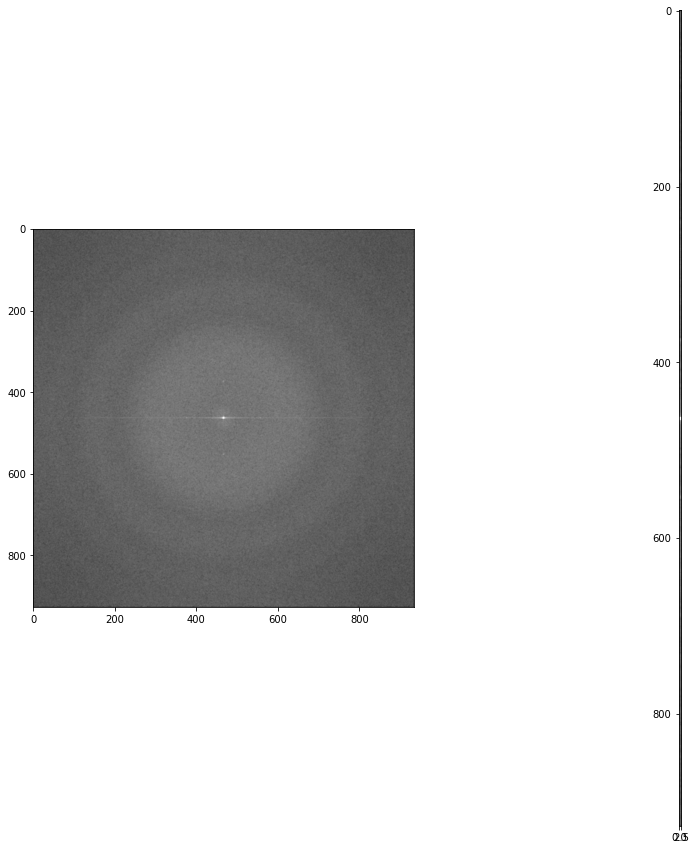

In [87]:
filtre_moyenneur = np.ones((3,3))/9
tdf_moyenne = signal.convolve2d(cryoem_tdf,filtre_moyenneur)
afficherColonneCentrale(tdf_moyenne)

#### **4. Calculer et appliquer le filtre correspondant.**

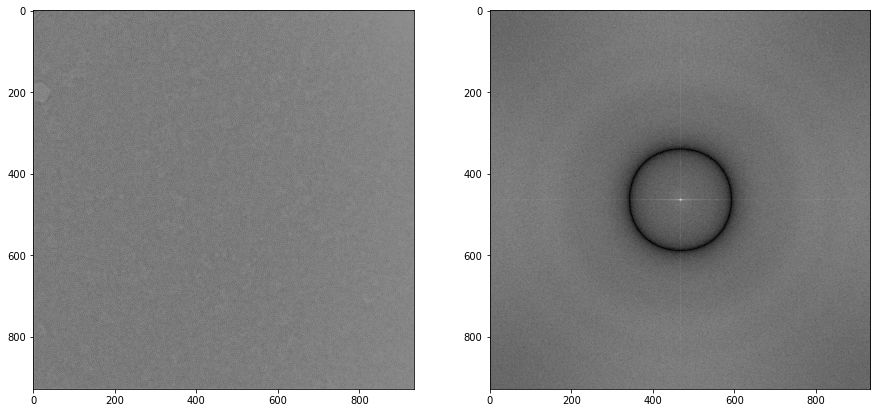

In [135]:
def distance(x,y,M,N):
    return np.sqrt((x-M/2)**2+(y-N/2)**2)

kernel_highpass = np.array([[-1, -1, -1],
[-1,  6, -1],
[-1, -1, -1]])

img_passe_bas = signal.convolve2d(skimage.color.rgb2gray(cryoem),kernel_highpass)
img_passe_bas_tdf = afficherTdF(img_passe_bas)

#### **5. Calculer une moyenne (par cercle) pour le profil.**

#### **6. Calculer un filtre correctif (attention aux valeurs nulles, filtre à appliquer à la TdF complexe, pas seulement à son module).**

# **Opérateurs de Prewitt et Sobel**
**Pour ces opérateurs, les dérivées directionnelles horizontale et verticale se calculent à partir des masques :**
$$ h1 = 
\begin{bmatrix}
1 & 0 & -1 \\
c & 0 & -c \\
1 & 0 & -1 
\end{bmatrix}
h2 =
\begin{bmatrix}
-1 & -c & -1 \\
0 & 0 & 0 \\
1 & c & 1
\end{bmatrix}
$$
**(pour Prewitt _c_ = 1, pour Sobel _c_ = 2)**

#### **1. Montrer que l’application de l’un de ces filtres permet d’approximer la dérivée première selon une certaine direction et la moyenne dans l’autre direction.****

Pour ces opérateurs, les dérivées directionnelles horizontale et verticale se calculent à partir des masques :

Nous savons que : $f'(x)=\lim_{h \to 0}\dfrac{f(x+h)-f(x)}{h}$.<br>
Cependant, nous savons également que : $f'(x)=\lim_{h \to 0}\dfrac{f(x+\dfrac{h}{2})-f(x-\dfrac{h}{2})}{h}$.<br>
Puisque nous sommes dans le cas discret, nous voulons utiliser les deux pixels voisins (précédent et suivant), c'est pourquoi nous prenons _h_=2.<br>
On obtient alors : $f'(x)=\dfrac{f(x+1)-f(x-1)}{2}$.<br>
Si on regarde à présent _h1_, on voit que que sur chaque ligne, on a les facteurs [_x_ 0 -_x_]. Si on prends _x_=1 par exemple, on obtient parfaitement la dernière formule citée.<br>
_h1_ approxime donc la dérivée première en _x_, tandis que _h2_ le fait en _y_.<br>
La moyenne dans l'autre direction vient du fait que ces filtres sont carrées et qu'on effectue donc la moyenne sur les lignes (resp. colonnes) dans _h1_ (resp. _h2_).<br>
Ces masques calculent donc le gradient dans une direction et effectuent un lissage dans la direction orthogonale.

#### **2. Quel est le rôle de _c_ ?**
Ici, _c_ agit comme un facteur, un poids pour la ligne (resp. colonne) à laquelle il appartient.<br>
Dans le cas de _h1_ (resp. _h2_), la ligne (resp. colonne) centrale aura d'avantage de poids que les autres, surtout lorsqu'on augmente la valeur de _c_.<br>
Ainsi, avec _c_ = 1, on obtient les masques de Prewitt, tandis qu'on a ceux de Sobel avec _c_ = 2, qui donnent ainsi un poids plus importants aux pixels plus proches du pixel central.

**Étudions par exemple les opérateurs Sobel (c = 2). Définir _h1_ et _h2_ en tapant par exemple : 
``
h1=[1 0 -1; 2 0 -2; 1 0 -1]
``**

#### **3. Appliquer ces filtres sur les images _onde4_ et _boisbruit_.**

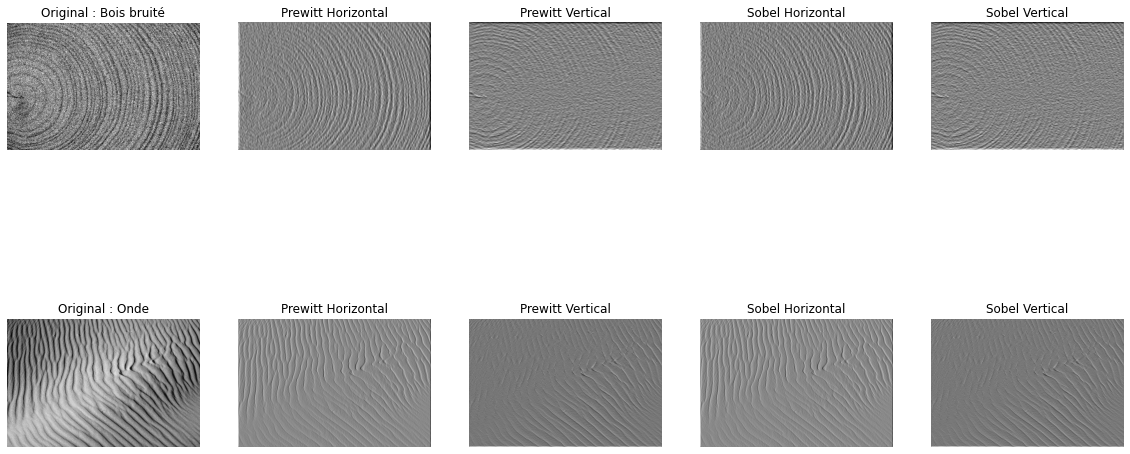

In [210]:
def getMasques(c):
    h1 = [[1, 0, -1], [c, 0, -c], [1, 0, -1]]
    h2 = [[-1, -c, -1], [0, 0, 0], [1, c, 1]]
    h3 = [[c, 1, 0],[1, 0, -1],[0, -1, -c]]
    h4 = [[0, 1, c],[-1, 0, 1],[-c, -1, 0]]
    return h1,h2,h3,h4

def getPrewitts():
    return getMasques(1)

def getSobels():
    return getMasques(2)

def convolveImage(image,h1,h2):
    return signal.convolve2d(image,h1),signal.convolve2d(image,h2)

onde4 = skimage.io.imread(my_path + "ondes4.jpg",as_gray=True)
boisbruit = skimage.util.random_noise(skimage.io.imread(my_path + "bois.jpeg",as_gray=True)) # null mean and 0.01 variance (default)

H1_Prewitt,H2_Prewitt,H3_Prewitt,H4_Prewitt = getPrewitts()
boisbruit_filtre1_Prewitt, boisbruit_filtre2_Prewitt = convolveImage(boisbruit,H1_Prewitt,H2_Prewitt)
onde4_filtre1_Prewitt, onde4_filtre2_Prewitt = convolveImage(onde4,H1_Prewitt,H2_Prewitt)

H1_Sobel, H2_Sobel, H3_Sobel, H4_Sobel = getSobels()
boisbruit_filtre1_Sobel, boisbruit_filtre2_Sobel = convolveImage(boisbruit,H1_Sobel,H2_Sobel)
onde4_filtre1_Sobel, onde4_filtre2_Sobel = convolveImage(onde4,H1_Sobel,H2_Sobel)

# Display the results
f, ax = plt.subplots(2,5)
ax[0][0].imshow(boisbruit,cmap="gray")
ax[0][0].set_title("Original : Bois bruité")
ax[0][1].imshow(boisbruit_filtre1_Prewitt,cmap="gray")
ax[0][1].set_title("Prewitt Horizontal")
ax[0][2].imshow(boisbruit_filtre2_Prewitt,cmap="gray")
ax[0][2].set_title("Prewitt Vertical")
ax[0][3].imshow(boisbruit_filtre1_Sobel,cmap="gray")
ax[0][3].set_title("Sobel Horizontal")
ax[0][4].imshow(boisbruit_filtre2_Sobel,cmap="gray")
ax[0][4].set_title("Sobel Vertical")
ax[1][0].imshow(onde4,cmap="gray")
ax[1][0].set_title("Original : Onde")
ax[1][1].imshow(onde4_filtre1_Prewitt,cmap="gray")
ax[1][1].set_title("Prewitt Horizontal")
ax[1][2].imshow(onde4_filtre2_Prewitt,cmap="gray")
ax[1][2].set_title("Prewitt Vertical")
ax[1][3].imshow(onde4_filtre1_Sobel,cmap="gray")
ax[1][3].set_title("Sobel Horizontal")
ax[1][4].imshow(onde4_filtre2_Sobel,cmap="gray")
ax[1][4].set_title("Sobel Vertical")
[axi.axis('off') for axi in ax.ravel()]
plt.show()

#### **4. A partir de cette étude, commenter la nature de ces filtrages et les principales caractéristiques (par exemple face au bruit).**
Ces filtrages semblent très efficace pour la détection de contours.<br>En effet, comme nous calculons les dérivées de l'intensité lumineuse en chaque point, les images résultantes nous indique les changements brusques de luminosité et exacerbe ainsi les contours de celles-ci.<br>Comparons les résultats des filtrages avec l'image bois original et sa version bruitée :

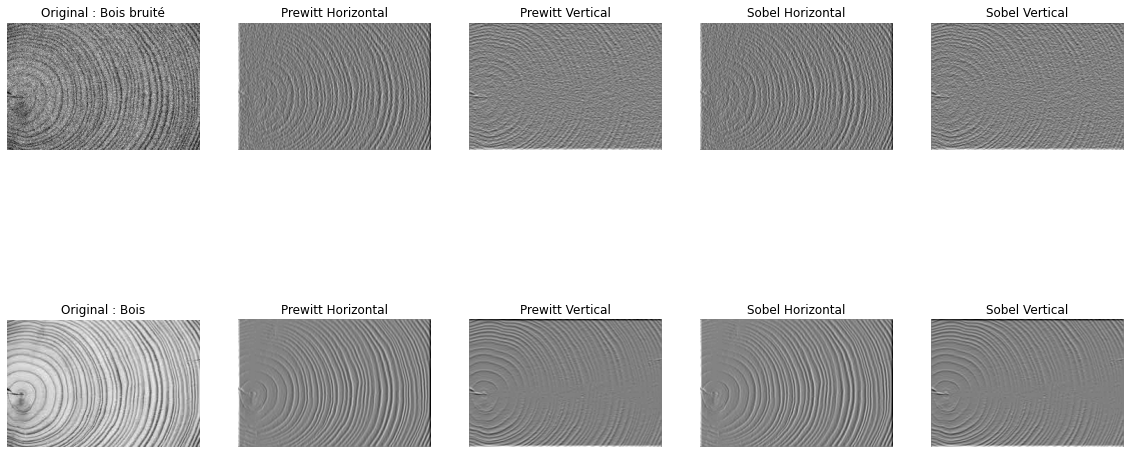

In [144]:
# Read the image
bois = skimage.io.imread(my_path + "bois.jpeg",as_gray=True)
# apply Prewitt filter
bois_filtre1_Prewitt, bois_filtre2_Prewitt = convolveImage(bois,H1_Prewitt,H2_Prewitt)
# apply Sobel filter
bois_filtre1_Sobel, bois_filtre2_Sobel  = convolveImage(bois,H1_Sobel,H2_Sobel)

# Display the results
f, ax = plt.subplots(2,5)
ax[0][0].imshow(boisbruit,cmap="gray")
ax[0][0].set_title("Original : Bois bruité")
ax[0][1].imshow(boisbruit_filtre1_Prewitt,cmap="gray")
ax[0][1].set_title("Prewitt Horizontal")
ax[0][2].imshow(boisbruit_filtre2_Prewitt,cmap="gray")
ax[0][2].set_title("Prewitt Vertical")
ax[0][3].imshow(boisbruit_filtre1_Sobel,cmap="gray")
ax[0][3].set_title("Sobel Horizontal")
ax[0][4].imshow(boisbruit_filtre2_Sobel,cmap="gray")
ax[0][4].set_title("Sobel Vertical")
ax[1][0].imshow(bois,cmap="gray")
ax[1][0].set_title("Original : Bois")
ax[1][1].imshow(bois_filtre1_Prewitt,cmap="gray")
ax[1][1].set_title("Prewitt Horizontal")
ax[1][2].imshow(bois_filtre2_Prewitt,cmap="gray")
ax[1][2].set_title("Prewitt Vertical")
ax[1][3].imshow(bois_filtre1_Sobel,cmap="gray")
ax[1][3].set_title("Sobel Horizontal")
ax[1][4].imshow(bois_filtre2_Sobel,cmap="gray")
ax[1][4].set_title("Sobel Vertical")
[axi.axis('off') for axi in ax.ravel()]
plt.show()

On se rend compte que les résultats sont assez différents entre la version originale et la version bruitée.<br>
Bien que ces filtres accentuent les contours et les détails, ils semblent également amplifier le bruit.
#### **5. En appliquant la transformée de Fourier avant et après le filtre, faire le lien avec les propriétés de la dérivée vue en TD.<br>C’est plus facile à visualiser en superposant une seule ligne des TF avant après.**

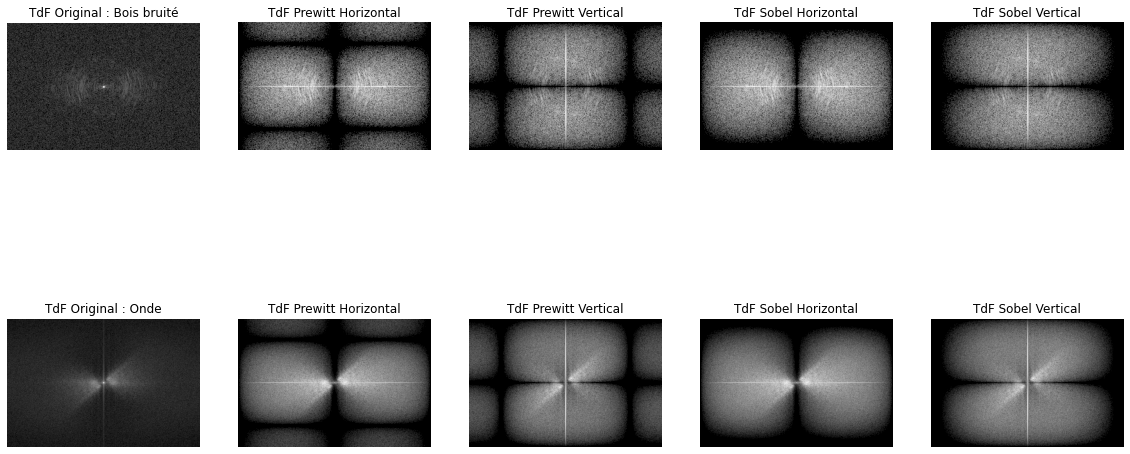

In [138]:
def calculerAllTdF(image,image1,image2,image3,image4):
    return  calculerTdF(image),calculerTdF(image1),calculerTdF(image2),calculerTdF(image3),calculerTdF(image4)

boisbruit_tfd, boisbruit_filtre1_Prewitt_tfd, boisbruit_filtre2_Prewitt_tfd, boisbruit_filtre1_Sobel_tfd, boisbruit_filtre2_Sobel_tfd = calculerAllTdF(boisbruit,boisbruit_filtre1_Prewitt,boisbruit_filtre2_Prewitt,boisbruit_filtre1_Sobel,boisbruit_filtre2_Sobel)
onde4_tfd, onde4_filtre1_Prewitt_tfd, onde4_filtre2_Prewitt_tfd, onde4_filtre1_Sobel_tfd, onde4_filtre2_Sobel_tfd = calculerAllTdF(onde4,onde4_filtre1_Prewitt,onde4_filtre2_Prewitt,onde4_filtre1_Sobel,onde4_filtre2_Sobel)

# Display the results
f, ax = plt.subplots(2,5)
ax[0][0].imshow(boisbruit_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[0][0].set_title("TdF Original : Bois bruité")
ax[0][1].imshow(boisbruit_filtre1_Prewitt_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[0][1].set_title("TdF Prewitt Horizontal")
ax[0][2].imshow(boisbruit_filtre2_Prewitt_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[0][2].set_title("TdF Prewitt Vertical")
ax[0][3].imshow(boisbruit_filtre1_Sobel_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[0][3].set_title("TdF Sobel Horizontal")
ax[0][4].imshow(boisbruit_filtre2_Sobel_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[0][4].set_title("TdF Sobel Vertical")
ax[1][0].imshow(onde4_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[1][0].set_title("TdF Original : Onde")
ax[1][1].imshow(onde4_filtre1_Prewitt_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[1][1].set_title("TdF Prewitt Horizontal")
ax[1][2].imshow(onde4_filtre2_Prewitt_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[1][2].set_title("TdF Prewitt Vertical")
ax[1][3].imshow(onde4_filtre1_Sobel_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[1][3].set_title("TdF Sobel Horizontal")
ax[1][4].imshow(onde4_filtre2_Sobel_tfd,norm=LogNorm(vmin=5),cmap="gray")
ax[1][4].set_title("TdF Sobel Vertical")
[axi.axis('off') for axi in ax.ravel()]
plt.show()

**Une fois le calcul du gradient effectué, on cherche en général à détecter les principales discontinuités du signal. Pour cela :**
- **On calcule la norme du gradient en tapant (si _res1_ et _res2_ sont les résultats des 2 filtrages précédents) : ``D=np.sqrt(np.square(res1)+np.square(res2)) ``**
- **Puis on seuille l’image de la norme (pour fixer le seuil on examine l’histogramme de la norme du gradient avec la fonction _plt.hist(image.flatten())_)**

#### **6. Appliquer la procédure proposée ci-dessus en explicitant vos choix afin d’extraire les contours les plus importants de l’image _objet_.**
Déterminons tout d'abord le seuillage que nous allons utiliser. Pour cela, on détermine l'histogramme ou l'histogramme cumulé de l'image.
J'ai préféré utiliser directement l'histogramme cumulé afin de déterminer plus aisément la valeur à utiliser.



Text(0.5, 1.0, 'Histogramme cumulé Sobel')

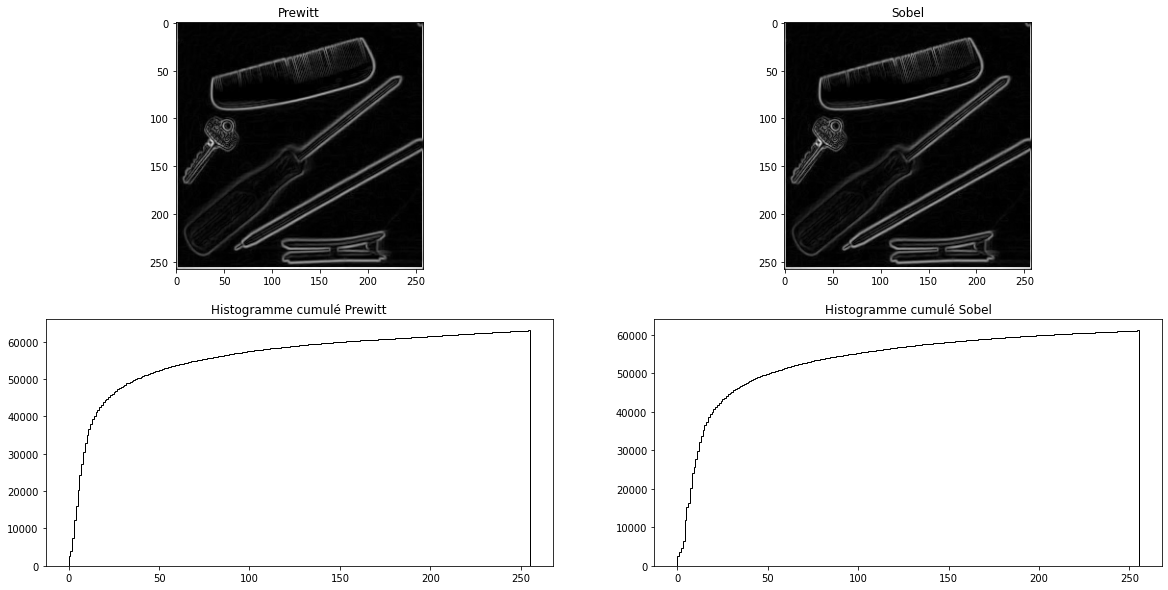

In [260]:
# import image "objet"
objets = skimage.io.imread(my_path+"objets.jpg", as_gray=True)
# apply  filters
objets_filtre1_Prewitt, objets_filtre2_Prewitt = convolveImage(objets,H1_Prewitt,H2_Prewitt)
objets_filtre1_Sobel, objets_filtre2_Sobel = convolveImage(objets,H1_Sobel,H2_Sobel)
# calculate gradients
gradient_Prewitt = np.sqrt(np.square(objets_filtre1_Prewitt)+np.square(objets_filtre2_Prewitt))
gradient_Sobel = np.sqrt(np.square(objets_filtre1_Sobel)+np.square(objets_filtre2_Sobel))
# calculate histograms
hist_Prewitt = plt.hist(gradient_Prewitt.flatten(),range=(0,255),bins=256)
hist_Sobel = plt.hist(gradient_Sobel.flatten(),range=(0,255),bins=256)
plt.close()

# Display the results
f, ax = plt.subplots(2,2)
ax[0][0].imshow(gradient_Prewitt,cmap="gray")
ax[0][0].set_title("Prewitt")
ax[0][1].imshow(gradient_Sobel,cmap="gray")
ax[0][1].set_title("Sobel")
ax[1][0].hist(gradient_Prewitt.flatten(),range=(0,255),bins=256, cumulative=True, histtype='step', color='black')
ax[1][0].set_title("Histogramme cumulé Prewitt")
ax[1][1].hist(gradient_Sobel.flatten(),range=(0,255),bins=256, cumulative=True,histtype='step', color='black')
ax[1][1].set_title("Histogramme cumulé Sobel")


De là, nous pouvons déduire nos seuils et effectuer le seuillage.<br> En effet, on se rend compte que on a environ un total de 65 000 pixels, si l'on veut seuiller à 90% afin de ne garder que les 10% les plus importants, il faut donc prendre l'abcisse de la valeur qui a pour ordonnée 65 000 * 0.9 = 58500.<br>Elle semble être autour de 80 pour Prewitt et 100 pour Sobel.
Ensuite, on ne garde uniquement que les valeurs supérieurs à ce seuil afin d'obtenir l'image résultat.

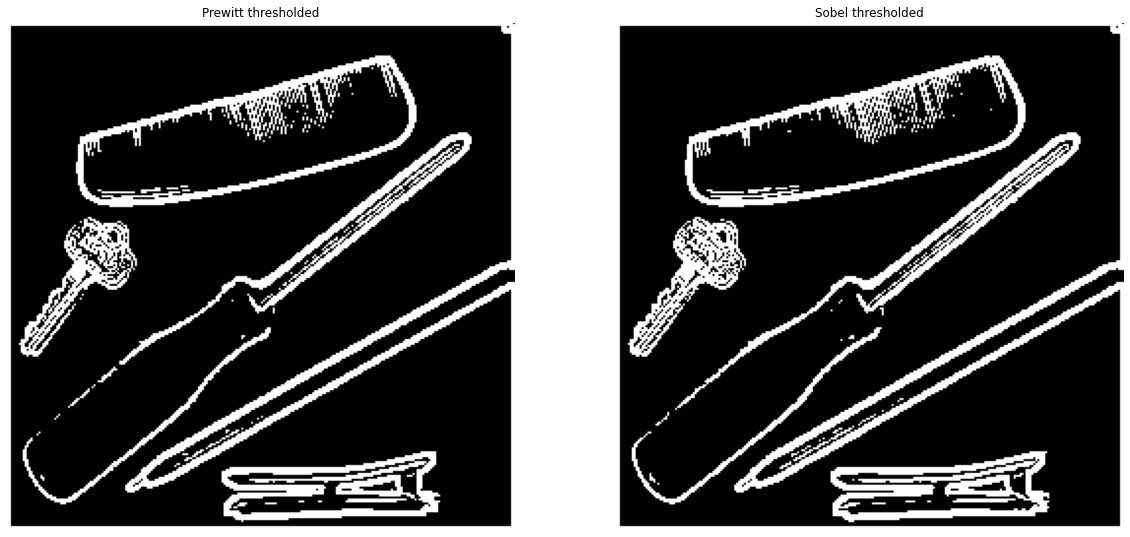

In [258]:
threshold_objets_Prewitt = 80
threshold_objets_Sobel = 100
# threshold images with Prewitt
thresholded_objets_Prewitt = np.where(gradient_Prewitt>threshold_objets_Prewitt,1,0)
thresholded_objets_Sobel = np.where(gradient_Sobel>threshold_objets_Sobel,1,0)
# Display the results
fig, ax = plt.subplots(1,2)
ax[0].imshow(thresholded_objets_Prewitt,cmap="gray")
ax[0].set_title("Prewitt thresholded")
ax[1].imshow(thresholded_objets_Sobel,cmap="gray")
ax[1].set_title("Sobel thresholded")
[axi.axis('off') for axi in ax.ravel()]
plt.show()



Ainsi, nous avons réussi à extraire les contours les plus importants de l'image _objets_.

**Toutefois, nous remarquons que ces masques n’approximent la dérivée que selon une direction horizontale ou verticale. On peut étudier le gradient selon des directions diagonales en utilisant, en plus des précédents, les masques :**
$$h3 = 
\begin{bmatrix}
c & 1 & 0 \\
1 & 0 & -1 \\
0 & -1 & -c
\end{bmatrix}
h4 =
\begin{bmatrix}
0 & 1 & c \\
-1 & 0 & 1 \\
-c & -1 & 0
\end{bmatrix}
$$


#### **7. Appliquer ces filtres sur l’image _bois_. Commenter.**

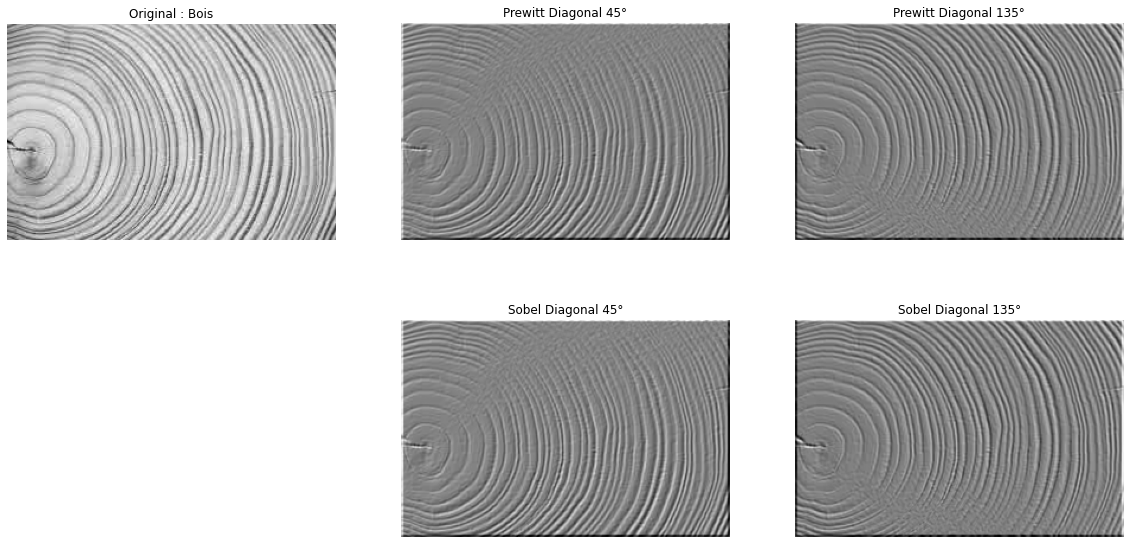

In [143]:
bois_filtre3_Prewitt, bois_filtre4_Prewitt = convolveImage(bois,H3_Prewitt,H4_Prewitt)
bois_filtre3_Sobel, bois_filtre4_Sobel = convolveImage(bois,H3_Sobel,H4_Sobel)

f, ax = plt.subplots(2,3)
ax[0][0].imshow(bois,cmap="gray")
ax[0][0].set_title("Original : Bois")
ax[0][1].imshow(bois_filtre3_Prewitt,cmap="gray")
ax[0][1].set_title("Prewitt Diagonal 45°")
ax[0][2].imshow(bois_filtre4_Prewitt,cmap="gray")
ax[0][2].set_title("Prewitt Diagonal 135°")
ax[1][1].imshow(bois_filtre3_Sobel,cmap="gray")
ax[1][1].set_title("Sobel Diagonal 45°")
ax[1][2].imshow(bois_filtre4_Sobel,cmap="gray")
ax[1][2].set_title("Sobel Diagonal 135°")
[axi.axis('off') for axi in ax.ravel()]
plt.show()


Tout comme nous avons pu extraire les contours avec filtres horizontaux et verticaux, il semble assez aisé de pouvoir le faire avec les filtres diagonaux en appliquant la même méthodologie.
